In [1]:
from scipy import integrate
import numpy as np
import math as m
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib.pyplot as plt
from ase.units import Bohr, Hartree

r=np.load('MoS2_alone_r.npy')
rx=r
ry=r
#W_ee=np.load('MoS2_alone_W_ee.npy')
W_eh=np.load('MoS2_alone_W_eh.npy')
W_ee=W_eh

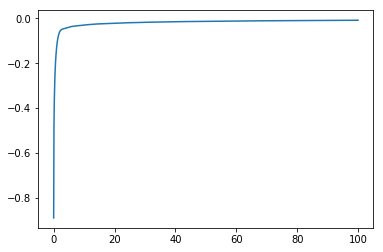

In [2]:
plt.plot(r,W_ee)

$$
\Psi=\frac{1}{\sqrt{2}}\frac{2}{\pi a b \sqrt{Norm}}(e^{-x/a}e^{-y/b}+e^{-y/a}e^{-x/b})
$$

$$
\sqrt{Norm}=\sqrt{1+\frac{16a^2b^2}{(a+b)^4}}
$$

In [3]:
from scipy.integrate import quad
# import numba

# @numba.jit(nopython=True)
def wave_exciton(x,a):
    return np.sqrt(2/(np.pi*a**2))*np.exp(-x/a)

# @numba.jit(nopython=True)
def wave_trion(x,y,a,b):
    Norm=np.sqrt(1+16*a**2*b**2/(a+b)**4)
    wave=wave_exciton(x,a)*wave_exciton(y,b)
    wave+=wave_exciton(x,b)*wave_exciton(y,a)
    wave/=np.sqrt(2)
    wave/=Norm
    return wave


In [4]:
def dens(rx,ry,a,b):
    return rx*ry*wave_trion(rx,ry,a,b)**2

def nor1(a,b):
    return (2*np.pi)**2*integrate.nquad(dens,[[rx[0],rx[-1]],[ry[0],ry[-1]]],
                                        args=(a,b),opts={'limit':200})[0]

def nor2(a,b):
    Norm=np.sqrt(1+16*a**2*b**2/(a+b)**4)
    return Norm

In [5]:
nor1(20,1)

0.9993215696657703

In [6]:
nor2(5,5)**2

2.0000000000000004

In [7]:
W_ee_new=np.zeros(len(W_ee)+1)
r_new=np.zeros(len(r)+1)

In [8]:
W_ee_new[0]=W_ee[0]
W_ee_new[1:]=W_ee
r_new[0]=0.
r_new[1:]=r

In [9]:
Wee = interp1d(r_new,W_ee_new,kind='linear',fill_value='extrapolate')
#plt.plot(r,Wee(r))
#plt.plot(r,W_ee,'k.')

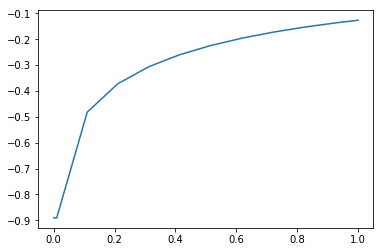

In [10]:
rr=np.linspace(0.,1,500)
plt.plot(rr,Wee(rr))

In [11]:
rx=r_new
ry=r_new

In [12]:
#Weh = interp1d(r_new,W_eh,kind='linear')
#plt.plot(r,Weh(r))
#plt.plot(r,W_eh,'k.')

##### $$
V_{1}=(2\pi)^2 \int_0^\infty\int_0^\infty{\Psi (r_{1}, r_{2})^2 W_{eh}(r_{1})r_{1} r_{2}dr_{1}dr_{2}}
$$

In [13]:
def integrand11(rx,ry,a,b):
    return 27.21*rx*ry*wave_trion(rx,ry,a,b)**2*Wee(rx)

def V11_new(a,b):
    return (2*np.pi)**2*integrate.nquad(integrand11,[[rx[0],rx[-1]],[ry[0],ry[-1]]],
                                        args=(a,b),opts={'limit':200})[0]

def integrand22(rx,ry,a,b):
    def W_rad(phi):
        r_new=rx*np.linalg.norm([ry/rx-np.cos(phi),np.sin(phi)])
        return Wee(r_new)
    return 27.21*rx*ry*wave_trion(rx,ry,a,b)**2*integrate.quad(W_rad, 0, 2*np.pi, limit=200)[0]
    
def V22_new(a,b):
    return 2*np.pi*integrate.nquad(integrand22,[[rx[0],rx[-1]],[ry[0],ry[-1]]],
                                        args=(a,b),opts={'limit':200})[0]

$$
V_{2}=(2\pi)^2 \int_0^\infty\int_0^\infty{\Psi (r_{1}, r_{2})^2 W_{eh}(|r_{1}-r_{2}|)r_{1} r_{2}dr_{1}dr_{2}}
$$

$$
K=\frac{Hartree}{m_{eff}(\sqrt{Norm})^2}(\frac{1}{2a^2}+\frac{1}{2b^2}+\frac{8(a^2+b^2)}{(a+b)^4})
$$

In [14]:
eff_mass=0.277
mh=0.56

def K11(a,b):
    Norm=1+16*a**2*b**2/(a+b)**4
    return Hartree*(1/(2*a**2)+1/(2*b**2)+8*(a**2+b**2)/(a+b)**4)/eff_mass/Norm+1/(2*mh*a*b)

$$
V_{3}=(2\pi)^2 \int_0^\infty\int_0^\infty{\Psi (r_{1}, r_{2})^2 W_{eh}(r_{2})r_{1} r_{2}dr_{1}dr_{2}}
$$

$$
H=K+2V_{1}-V_{2}
$$

In [15]:
x=np.zeros(2)

def gs(x):
    return K11(x[0],x[1])+2*V11_new(x[0],x[1])-V22_new(x[0],x[1])

In [30]:
from scipy.optimize import minimize

value_min = minimize(gs, [10, 25],bounds=[(0,30),(0,30)],method='L-BFGS-B',options={'disp':1})

value_min

/home/natasha/anaconda3/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if sys.path[0] == '':


KeyboardInterrupt: 

In [ ]:
V22_new(10,15)

/home/natasha/anaconda3/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if sys.path[0] == '':
/home/natasha/anaconda3/envs/mypy3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
/home/natasha/anaconda3/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and c